In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [0]:
import dataset

# Prepare & Process Data

In [0]:
#get data
forex_data = pd.read_csv('EURUSD.I60.csv')
forex_data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
forex_data = forex_data[['Date', 'Time', 'Open', 'High', 'Low', 'Close']]

In [0]:
#visualize data
forex_data.head()

,Date,Time,Open,High,Low,Close
0,2012.08.10,0:00,1.23040,1.23050,1.22981,1.23023
1,2012.08.10,1:00,1.23021,1.23023,1.22921,1.22926
2,2012.08.10,2:00,1.22925,1.23000,1.22905,1.22976
3,2012.08.10,3:00,1.22973,1.22976,1.22904,1.22960
4,2012.08.10,4:00,1.22964,1.22978,1.22911,1.22957


In [0]:
#prepare close data for training
close_data = forex_data.Close

In [0]:
#scale data
scaler = MinMaxScaler()
close_data = close_data.values.reshape(close_data.shape[0], 1)
close_data = scaler.fit_transform(close_data)

In [0]:
#preprocess data
X,y = dataset.process_data(close_data, 20)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

33468
8368
33468
8368


# Build Model

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM, Dense

In [0]:
#keras callbacks
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 )

In [0]:
model = Sequential()
model.add(CuDNNLSTM(512,input_shape=(20,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=500, callbacks = [cp_callback], validation_data=(X_test,y_test),shuffle=False)

Train on 33468 samples, validate on 8368 samples
Epoch 1/500
33152/33468 [============================>.] - ETA: 0s - loss: 9.6699e-04
Epoch 00001: saving model to training_1/cp.ckpt
33468/33468 [==============================] - 13s 378us/sample - loss: 9.6935e-04 - val_loss: 0.0119
Epoch 2/500
33120/33468 [============================>.] - ETA: 0s - loss: 9.6893e-04
Epoch 00002: saving model to training_1/cp.ckpt
33468/33468 [==============================] - 5s 163us/sample - loss: 9.7540e-04 - val_loss: 0.0126
Epoch 3/500
33376/33468 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00003: saving model to training_1/cp.ckpt
33468/33468 [==============================] - 6s 164us/sample - loss: 0.0011 - val_loss: 0.0101
Epoch 4/500
33344/33468 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00004: saving model to training_1/cp.ckpt
33468/33468 [==============================] - 5s 164us/sample - loss: 0.0013 - val_loss: 0.0095
Epoch 5/500
33120/33468 [=

# Save And Evaluate Model

In [0]:
model.save('forex_60.h5')

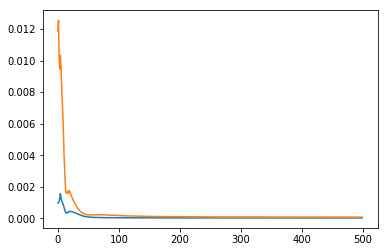

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Prediction on Test Data

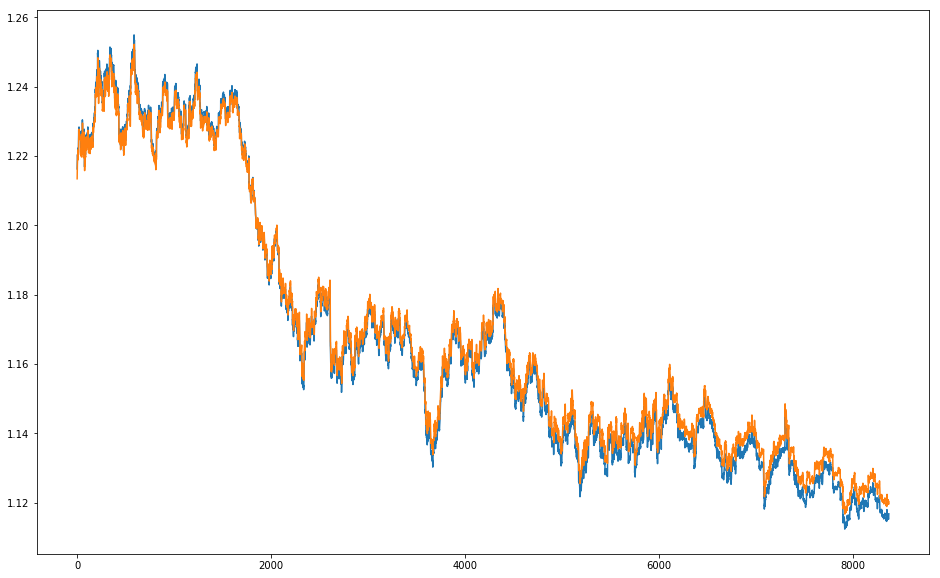

In [0]:
y_pred = model.predict(X_test)
plt.figure(figsize=(16, 10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scaler.inverse_transform(y_pred))

# Prediction on Live Data

In [0]:
#API URL
API_KEY = '5A6G0YMZYC5EQ6Z0'
url = 'https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=60min&apikey=5A6G0YMZYC5EQ6Z0&datatype=csv'
intraday_data = pd.read_csv(url)
intraday_data.head()

,timestamp,open,high,low,close
0,2019-06-28 21:00:00,1.1373,1.1373,1.1373,1.1373
1,2019-06-28 20:00:00,1.1372,1.1372,1.1365,1.1369
2,2019-06-28 19:00:00,1.1377,1.1377,1.1368,1.1372
3,2019-06-28 18:00:00,1.1369,1.1378,1.1364,1.1377
4,2019-06-28 17:00:00,1.1359,1.1369,1.1354,1.1369


# Scale and Process Live Data

In [0]:
#reverse data order
intraday_close = intraday_data.close[::-1]

In [0]:
scaler = MinMaxScaler()
intraday_close = intraday_close.values.reshape(intraday_close.shape[0], 1)
intraday_close = scaler.fit_transform(intraday_close)

In [0]:
X_live, y_live =  dataset.process_data(intraday_close, 20)
X_live = X_live.reshape((X_live.shape[0],X_live.shape[1],1))

# Load Model

In [0]:
from tensorflow.keras.models import load_model
fx60_model = load_model('forex_60.h5')

# Predict Live Data

In [0]:
live_predictions = fx60_model.predict(X_live)

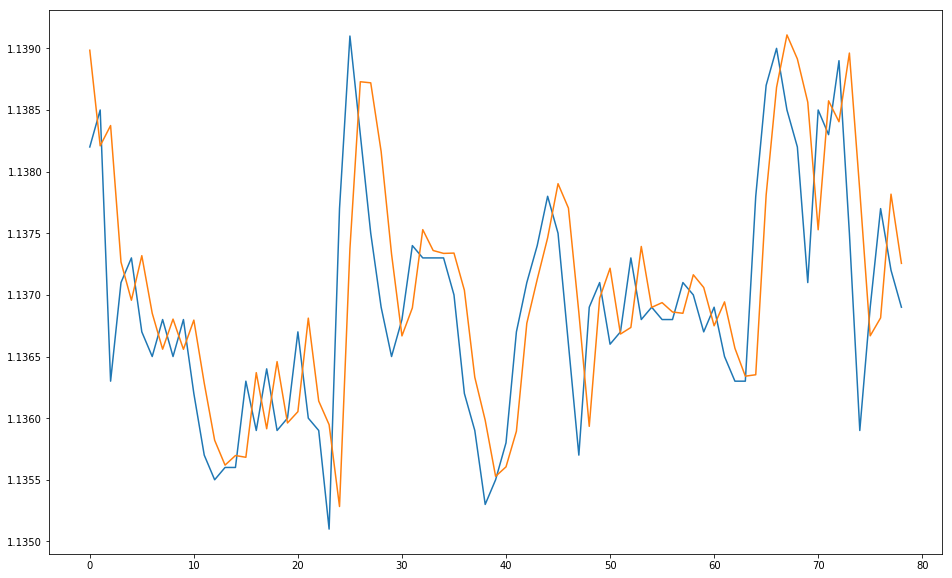

In [78]:
plt.figure(figsize=(16, 10))
plt.plot(scaler.inverse_transform(y_live.reshape(-1,1)))
plt.plot(scaler.inverse_transform(live_predictions))